In [ ]:
pip install torch torchvision


In [ ]:
import os
import time
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
from nltk.tokenize import word_tokenize

# Ensure NLTK data is downloaded
nltk.download('punkt')

# Define the TextEncoder class
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return h[-1]

# Function to read the label.txt file and preprocess the text
def read_label_file(filepath):
    with open(filepath, 'r') as file:
        text = file.read().strip()
    return text

# Function to build vocabulary from the list of sentences
def build_vocab(sentences):
    all_tokens = [word for sentence in sentences for word in word_tokenize(sentence)]
    vocab = {word: idx for idx, word in enumerate(set(all_tokens), start=1)}
    vocab['<PAD>'] = 0  # Add a padding token with index 0
    return vocab

# Function to convert sentences to token indices
def sentence_to_indices(sentence, vocab):
    return [vocab[word] for word in word_tokenize(sentence) if word in vocab]

# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, root_dir, vocab):
        self.root_dir = root_dir
        self.folders = [os.path.join(root_dir, folder) for folder in os.listdir(root_dir)]
        self.vocab = vocab

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_path = self.folders[idx]
        label_file = os.path.join(folder_path, 'label.txt')
        sentence = read_label_file(label_file)
        token_indices = sentence_to_indices(sentence, self.vocab)
        return torch.tensor(token_indices)

# Main code to process the text data
root_dir = '/content/drive/MyDrive/Test_out/Feature/Train'
all_sentences = []

# Collect all sentences to build the vocabulary
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
        label_file = os.path.join(folder_path, 'label.txt')
        sentence = read_label_file(label_file)
        all_sentences.append(sentence)

# Build vocabulary
vocab = build_vocab(all_sentences)
vocab_size = len(vocab)

# Define parameters for the TextEncoder
embed_size = 50
hidden_size = 100

# Create TextEncoder instance
text_encoder = TextEncoder(vocab_size, embed_size, hidden_size)

# Create dataset and dataloader
dataset = TextDataset(root_dir, vocab)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=lambda x: nn.utils.rnn.pad_sequence(x, batch_first=True))

# Encode the sentences using the TextEncoder
for batch in dataloader:
    encoded_sentences = text_encoder(batch)
    print(encoded_sentences)

# Save the encoded sentences if needed
# torch.save(encoded_sentences, 'encoded_sentences.pt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


tensor([[ 0.0928, -0.0139,  0.1071,  0.2626,  0.0875, -0.0897, -0.2148,  0.0372,
         -0.0883,  0.1366,  0.1413, -0.0006,  0.0267,  0.0100, -0.0105, -0.0277,
         -0.1831,  0.0693, -0.0228,  0.0258, -0.0148,  0.0504, -0.0644, -0.2375,
         -0.1097, -0.0780, -0.0091, -0.0536, -0.0007,  0.1081, -0.0341, -0.0915,
         -0.0976, -0.1534,  0.2155,  0.2613,  0.1047, -0.0697,  0.0107,  0.1585,
         -0.1159,  0.2233, -0.0093, -0.1133,  0.0980,  0.2616, -0.0664,  0.0439,
          0.2240,  0.0839,  0.2009, -0.0743,  0.0949,  0.1216,  0.1468,  0.0606,
         -0.0424,  0.0733, -0.0670, -0.0482,  0.0560, -0.0878,  0.1025, -0.0513,
         -0.1243,  0.0482,  0.0703,  0.0376, -0.0237,  0.0464,  0.0026, -0.0315,
          0.0992,  0.1136,  0.1324,  0.1048,  0.1503,  0.0139, -0.1741,  0.1484,
         -0.1030,  0.1007, -0.0403,  0.0840, -0.2207,  0.0626,  0.0689, -0.0308,
          0.0376,  0.1419,  0.1539, -0.0509, -0.0023,  0.1073,  0.1967, -0.0233,
         -0.1340,  0.0435, -

In [ ]:


class SignLanguageDataset(Dataset):
    def __init__(self, root_dir, transform=None,encoded_labels=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.load_data() # Call the load_data method to populate self.data during initialization
        self.encoded_labels = encoded_labels
        print(f"Loaded {len(self.encoded_labels)} samples from {self.root_dir}")

    def load_data(self): # Correct the indentation here
        for subdir in [ 'Train']:
            subdir_path = os.path.join(self.root_dir, subdir)
            for folder in os.listdir(subdir_path):
                folder_path = os.path.join(subdir_path, folder)
                label_path = os.path.join(folder_path, 'label.txt')
                if os.path.isdir(folder_path) and os.path.exists(label_path):
                    with open(label_path, 'r') as file:
                        label = file.read().strip()
                    for img_file in os.listdir(folder_path):
                        if img_file.endswith('.jpg') or img_file.endswith('.png'):
                            img_path = os.path.join(folder_path, img_file)
                            self.data.append((img_path, label))
        print(f"Loaded data from subdirectories: dev, train, test")

    def __len__(self):
        return len(self.encoded_labels)

    def __getitem__(self, idx):  # Corrected indentation
        img_path, _ = self.data[idx]  # Ignore the original label
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        encoded_label = self.encoded_labels[idx]  # Get encoded label
        return image, encoded_label

# Data transformations
transform = transforms.Compose([
    transforms.Resize((210, 300)),
    transforms.ToTensor(),
])
encoded_sentences_list = []
text_encoder.to(device) # Move the text_encoder to the GPU
for batch in dataloader:
  batch = batch.to(device)
  encoded_sentences_list.append(text_encoder(batch))
encoded_sentences = torch.cat(encoded_sentences_list, dim=0)

# Load datasets
train_dataset_1 = SignLanguageDataset(root_dir='/content/drive/MyDrive/Test_out/Feature', transform=transform,encoded_labels=encoded_sentences)
# train_dataset.data = train_dataset.data[:1000]  # Use only the first 1000 samples for testing
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
# print(f"Total training samples: {len(train_dataset)}")
# Similarly, you can load dev and test datasets


Loaded data from subdirectories: dev, train, test
Loaded 12 samples from /content/drive/MyDrive/Test_out/Feature


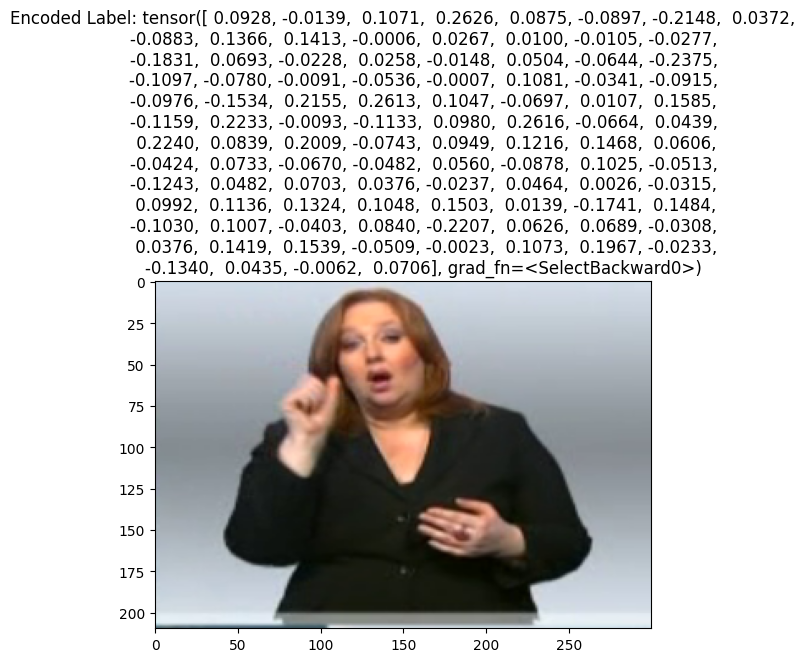

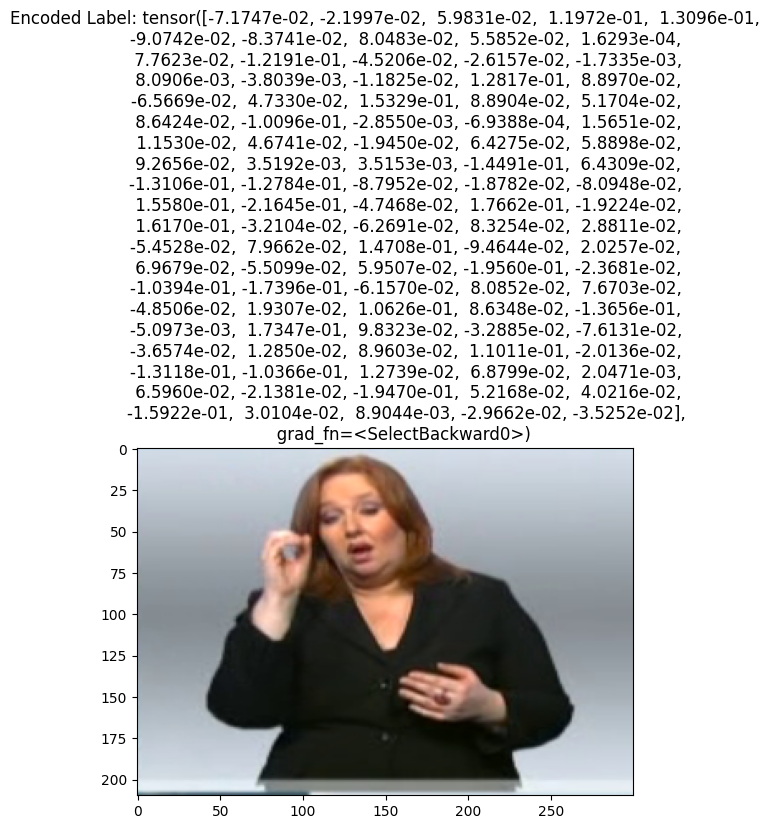

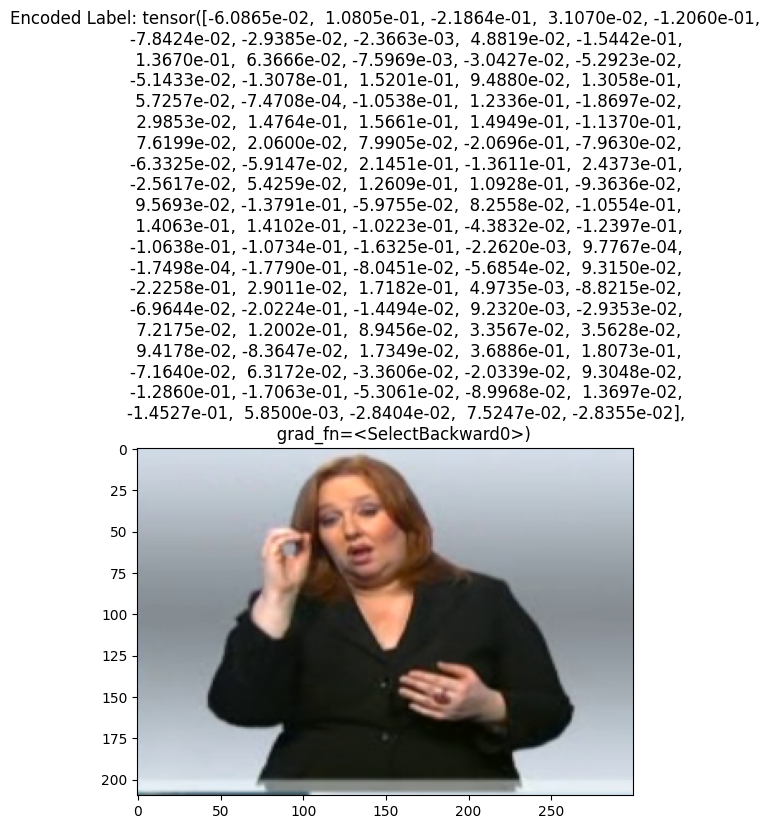

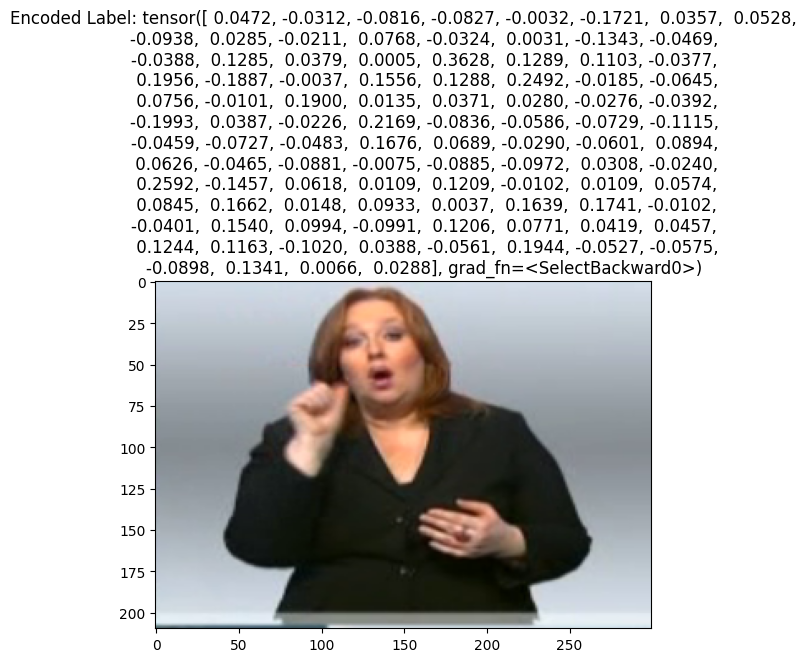

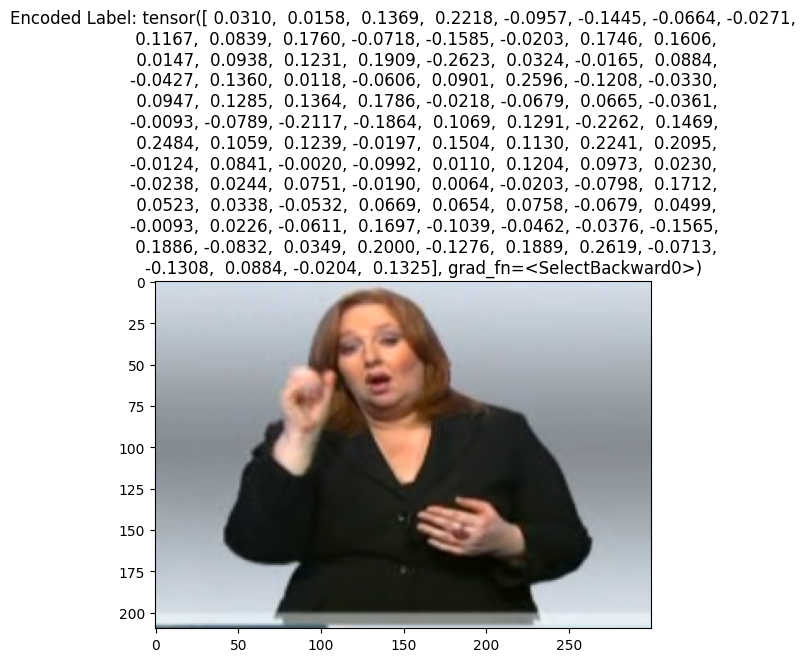

In [ ]:
import matplotlib.pyplot as plt

# Choose the number of samples to display
num_samples_to_display = 5

for i in range(num_samples_to_display):
    image, label = train_dataset_1[i]

    # Display the image
    plt.figure()  # Create a new figure for each image
    plt.imshow(image.permute(1, 2, 0))  # Rearrange dimensions and display
    plt.title(f"Encoded Label: {label}")  # Set the title with the encoded label
    plt.show()

In [ ]:
class SimplifiedImageEncoder(nn.Module):
    def __init__(self):
        super(SimplifiedImageEncoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 52 * 75, 512)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class CrossModalDiscriminator(nn.Module):
    def __init__(self, hidden_size):
        super(CrossModalDiscriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + 512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, text_features, image_features):
        combined = torch.cat((text_features, image_features), dim=1)
        return self.fc(combined)

Train set up


In [ ]:

num_epochs = 20  # Use fewer epochs for initial testing

# Initialize models and move to GPU
text_encoder = TextEncoder(vocab_size, embed_size, hidden_size).to(device)
image_encoder = SimplifiedImageEncoder().to(device)
discriminator = CrossModalDiscriminator(hidden_size).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(
    list(text_encoder.parameters()) +
    list(image_encoder.parameters()) +
    list(discriminator.parameters()),
    lr=0.001
)

# Extract all unique characters from the labels
# all_text = ''.join([label for _, label in train_dataset.data])
char2idx = {char: idx for idx, char in enumerate(set(all_sentences))}
print(f"Character to index mapping: {char2idx}")



Character to index mapping: {'aber südlich des mains bleibt es meist trocken wo bis zum späten nachmittag und vor allen dingen an den alpen scheint zeitweise die sonne': 0, 'aber in bayern sind noch einige gewitter unterwegs und deswegen gab es auch dort nochmal die unwetterwarnung des deutschen wetterdienstes hauptsächlich vor starken dauerregen und zum teil auch vor hagel': 1, 'besonders in den alpenregionen besteht hochwasser und überschwemmungsgefahr vor erdrutschen wird gewarnt': 2, 'die sonne kommt bruzzelt diese nebelfelder weg': 3, 'auch am sonntag viele wolken vor allem im osten und süden schneit es noch kräftiger sonst lässt der schneefall allmählich nach': 4, 'am tag im norden frischer bis starker wind dort sowie auf den bergen sind sturmböen mit dabei': 5, 'deutschlandweit bleibt es trocken': 6, 'am tag drei grad im berchtesgadener land und elf grad am niederrhein': 7, 'zunächst bleibt es noch verhältnismäßig mild nächste woche wird es dann kühler': 8, 'am sonntag lässt zum

In [ ]:
def print_gradients(model):
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            print(f"{name}: {param.grad.norm()}")

In [ ]:
# Assuming 'train_dataset' is already defined
import torch
from torch.utils.data import DataLoader

# Define batch size
batch_size =32

# Create DataLoader
train_loader = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    for i, (images, labels) in enumerate(train_loader):  # 'train_loader' is now defined
        batch_start_time = time.time()

        if i == 0:
            print(f"Epoch {epoch+1}: Loaded first batch of size {images.size(0)}")

        # Move images to GPU
        images = images.to(device)

        # Convert labels to tensors
        print("First label in the batch:", labels[0])
        ...

Epoch 1: Loaded first batch of size 6
First label in the batch: tensor([ 0.0760,  0.0830,  0.0470,  0.1597, -0.1100, -0.2156,  0.0583,  0.0192,
        -0.1173,  0.1506, -0.1232,  0.0096,  0.0134, -0.0721, -0.1256,  0.1531,
         0.1109, -0.0826, -0.2064,  0.0034, -0.0679,  0.0878,  0.0233,  0.1370,
        -0.0646, -0.1787, -0.1490, -0.1006,  0.1905,  0.2432, -0.0425, -0.1169,
         0.0195, -0.0283,  0.0282,  0.0735,  0.0569, -0.0418, -0.0971,  0.1091,
         0.0140, -0.2223, -0.0007,  0.1165,  0.0435,  0.2293, -0.0163,  0.1274,
         0.0642, -0.0176,  0.1190, -0.0095, -0.1385, -0.1480,  0.1118, -0.1119,
        -0.0567,  0.1488,  0.0711,  0.1614,  0.0775, -0.2328, -0.0352, -0.1742,
         0.0610, -0.1978,  0.2050,  0.0150,  0.1380, -0.0775,  0.0698,  0.1413,
         0.0705, -0.0420,  0.1138, -0.0251,  0.0189,  0.0721, -0.1319,  0.1822,
        -0.0138,  0.0631,  0.0035, -0.0640,  0.0420,  0.0564,  0.0681,  0.0242,
         0.1586,  0.1128, -0.0139, -0.0409, -0.1080,  0.

In [ ]:
# Your dictionary


# Extract keys and values
keys = list(char2idx.keys())
values = list(char2idx.values())

print("Keys:", keys)
print("Values:", values)


Keys: ['aber südlich des mains bleibt es meist trocken wo bis zum späten nachmittag und vor allen dingen an den alpen scheint zeitweise die sonne', 'aber in bayern sind noch einige gewitter unterwegs und deswegen gab es auch dort nochmal die unwetterwarnung des deutschen wetterdienstes hauptsächlich vor starken dauerregen und zum teil auch vor hagel', 'besonders in den alpenregionen besteht hochwasser und überschwemmungsgefahr vor erdrutschen wird gewarnt', 'die sonne kommt bruzzelt diese nebelfelder weg', 'auch am sonntag viele wolken vor allem im osten und süden schneit es noch kräftiger sonst lässt der schneefall allmählich nach', 'am tag im norden frischer bis starker wind dort sowie auf den bergen sind sturmböen mit dabei', 'deutschlandweit bleibt es trocken', 'am tag drei grad im berchtesgadener land und elf grad am niederrhein', 'zunächst bleibt es noch verhältnismäßig mild nächste woche wird es dann kühler', 'am sonntag lässt zumindest der wind nach sonst ändert sich wenig', 'v

In [ ]:
text_labels_indices = keys

In [ ]:
# Assuming you have a vocabulary 'vocab'
text_labels_indices = [[vocab[token] for token in sentence.split()] for sentence in text_labels_indices]  # Convert strings to indices using vocab

# Pad sequences to have the same length (if needed by your encoder)
text_labels_tensor = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(indices) for indices in text_labels_indices],
    batch_first=True, padding_value=0
)

# Ensure text_labels_tensor is on the same device as your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device
text_labels_tensor = text_labels_tensor.to(device)  # Move tensor to device

# Now pass this tensor to your text encoder
text_features = text_encoder(text_labels_tensor)

In [ ]:


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        image_features = image_encoder(images)

        outputs = discriminator(text_features, image_features)

        # Calculate loss
        real_labels = torch.ones(outputs.size(0), 1).to(device)
        loss = criterion(outputs, real_labels)

        print(f"Loss before backward: {loss.item()}")

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        print(f"Loss after backward: {loss.item()}")

        batch_end_time = time.time()
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}, Batch Time: {batch_end_time - batch_start_time:.4f} sec')

    # The following two lines were incorrectly indented
    epoch_end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_end_time - epoch_start_time:.4f} sec")

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 12 but got size 6 for tensor number 1 in the list.